### Before we get the data, let's import all required libraries

In [1]:

import pandas as pd

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import requests
from bs4 import BeautifulSoup
import os
from sklearn.cluster import KMeans
!pip install folium
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


print('Libraries imported.')

     |████████████████████████████████| 94 kB 6.2 MB/s  eta 0:00:01
Libraries imported.


### My variables

In [2]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'KYFZV5L3OBXCG2JJOVLJHHIJKAT0E2QU2F4PKMUNHTSHZBHX' # your Foursquare ID
CLIENT_SECRET = '0EHL4R4WUHUVOFUBNC3Q5DA4D0QGHK3FY0WKNVI20WGIGOGG' # your Foursquare Secret
VERSION = '20210218' # Foursquare API version

### Define the functions we are going to use later in this project

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude



def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
#Define a function to get venue details like like count , rating , tip counts for a given venue id. to be used for ranking.

def get_venue_details(venue_id):
  
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df



def get_venue_details(venue_id):
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [4]:
# get new york data
new_york_data=get_new_york_data()

new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
new_york_data.shape       

(306, 4)

So there are total of 306 different Neighborhoods in New York.

### Initial Data Analysis
Now let's analyze our initial data.

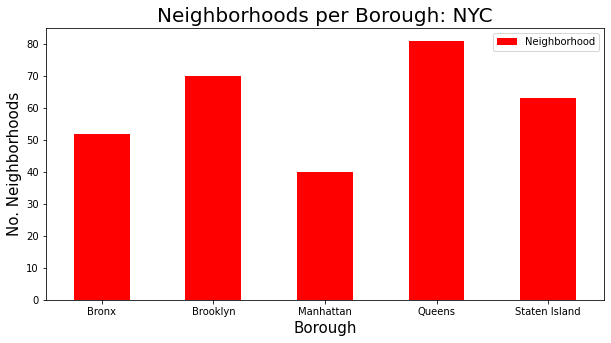

In [6]:
clr = "red"
new_york_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [7]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:2
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:1
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [8]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,55dfa36a498e164ef19bef7b,Premium Sweets & Restaurant
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird


In [9]:
indian_rest_ny.shape

(154, 4)

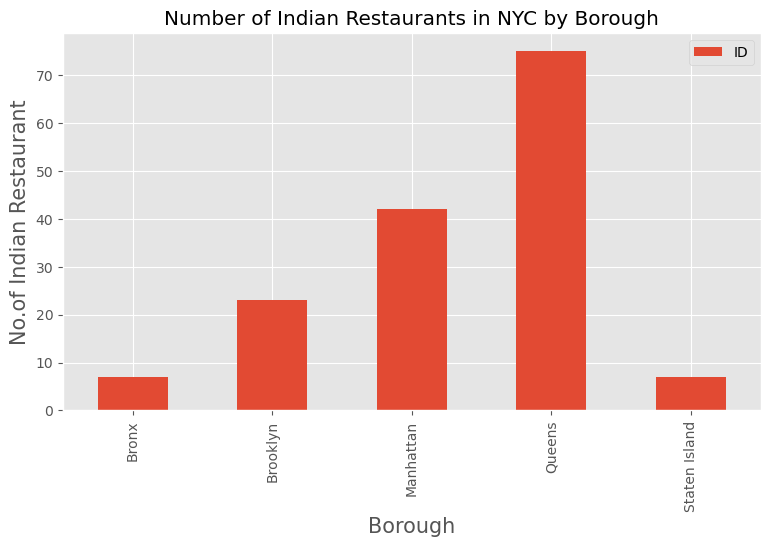

In [10]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

This shows that Queens has the highest number of Indian Restaurants.

In [11]:
indian_rest_ny[indian_rest_ny['Borough']=='Queens']

,Borough,Neighborhood,ID,Name
57,Queens,Astoria,4aa56c81f964a5204e4820e3,Seva Indian Cuisine
58,Queens,Astoria,5d8d9c5e0a2ffc0008f28855,The Gully
59,Queens,Astoria,59b9d25d0d173f3bdf654d77,Tikka Indian Grill
60,Queens,Astoria,562035d9498e2abb4137c2c7,Yaar Indian Restaurant
61,Queens,Woodside,4c7060e734443704ca0e245f,Kababish
62,Queens,Woodside,4afdcf29f964a520162b22e3,Rajbhog Sweets
63,Queens,Woodside,4b998d3ff964a520fc8235e3,Maharaja Sweets & Snacks
64,Queens,Woodside,5da4fbf091a08400078be19d,Angel Indian Restaurant
65,Queens,Woodside,49ebb18ff964a52016671fe3,Delhi Heights
66,Queens,Woodside,4b189424f964a52043d423e3,Dera


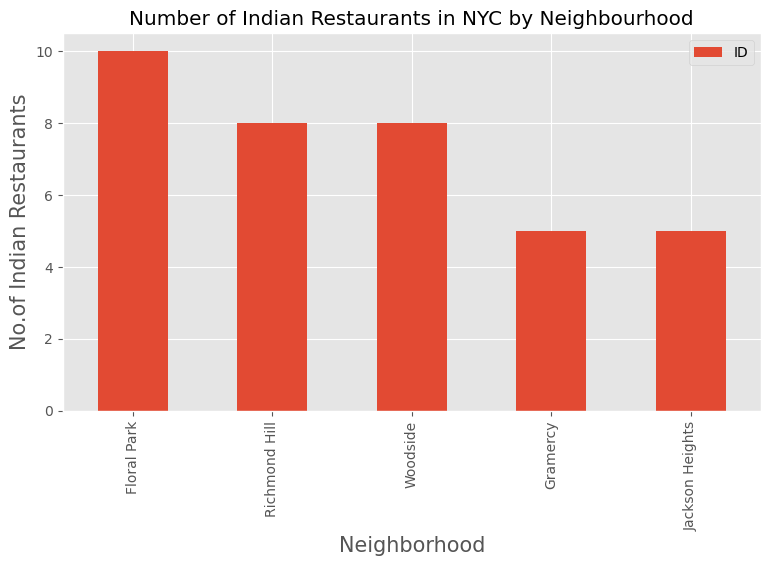

In [12]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [13]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
109,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
110,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
111,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
112,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
113,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
114,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
115,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
116,Queens,Floral Park,51d84192498ea979a3c4f13d,Sunshine Grill & Restaurant
117,Queens,Floral Park,4ec1b54f4690d2338a359d66,Tabaq Kebab Grill
118,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


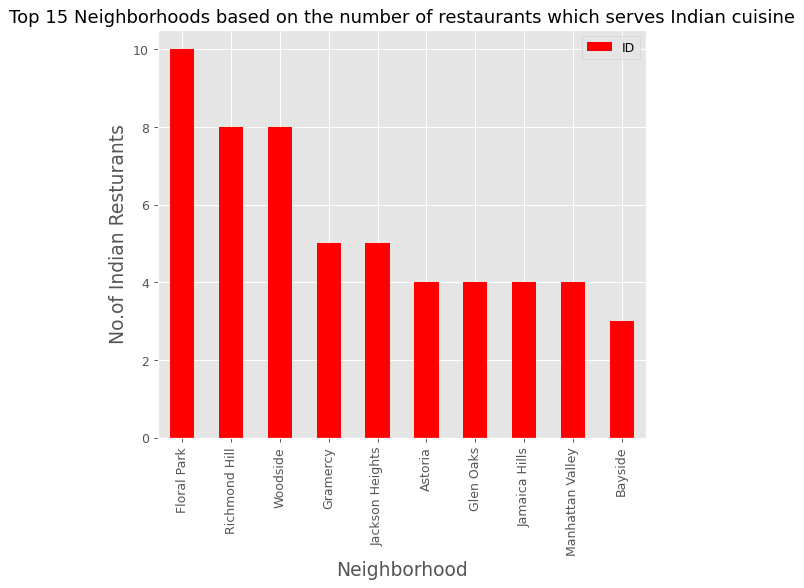

In [45]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,6), dpi = 90)
# title
plt.title('Top 15 Neighborhoods based on the number of restaurants which serves Indian cuisine')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar', color='RED')
#legend
plt.legend()
#displays the plot
plt.show()

In [15]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park'].count()

Borough         10
Neighborhood    10
ID              10
Name            10
dtype: int64

Floral Park in Queens has the most Indian Resturants with a total count of 10.

In [16]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.6    10
( 1 / 154 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55dfa36a498e164ef19bef7b
( 2 / 154 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.8     2
( 3 / 154 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.1     9
( 4 / 154 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.9     3
( 5 / 154 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     5.8     2
( 6 / 154 ) processed
                         ID       Name  Likes  Rat

No data available for id= 4aa56c81f964a5204e4820e3
( 58 / 154 ) processed
No data available for id= 5d8d9c5e0a2ffc0008f28855
( 59 / 154 ) processed
No data available for id= 59b9d25d0d173f3bdf654d77
( 60 / 154 ) processed
No data available for id= 562035d9498e2abb4137c2c7
( 61 / 154 ) processed
No data available for id= 4c7060e734443704ca0e245f
( 62 / 154 ) processed
No data available for id= 4afdcf29f964a520162b22e3
( 63 / 154 ) processed
No data available for id= 4b998d3ff964a520fc8235e3
( 64 / 154 ) processed
No data available for id= 5da4fbf091a08400078be19d
( 65 / 154 ) processed
No data available for id= 49ebb18ff964a52016671fe3
( 66 / 154 ) processed
No data available for id= 4b189424f964a52043d423e3
( 67 / 154 ) processed
No data available for id= 4e334b7bb0fb17f64f81a8b2
( 68 / 154 ) processed
No data available for id= 3fd66200f964a52009f11ee3
( 69 / 154 ) processed
No data available for id= 527d9cbc498edf0db10bde6b
( 70 / 154 ) processed
No data available for id= 4b998d3ff964

In [17]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Parkchester,0,0,0,0.0,0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.8,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3


In [18]:
indian_rest_stats_ny.shape


(154, 7)

In [19]:
indian_rest_ny.shape

(154, 4)

In [20]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [21]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [22]:
indian_rest_stats_ny_csv.shape

(154, 7)

In [23]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Parkchester,0,0,0,0.0,0
2,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.8,2
3,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
4,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3


In [24]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       154 non-null    object 
 1   Neighborhood  154 non-null    object 
 2   ID            154 non-null    object 
 3   Name          154 non-null    object 
 4   Likes         154 non-null    object 
 5   Rating        154 non-null    float64
 6   Tips          154 non-null    object 
dtypes: float64(1), object(6)
memory usage: 8.5+ KB


In [25]:
# Converting Likes and Tips to datatype float
#indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
#indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

convert_types = { 'Likes': float, 'Tips': float }
indian_rest_stats_ny = indian_rest_stats_ny.astype(convert_types)
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       154 non-null    object 
 1   Neighborhood  154 non-null    object 
 2   ID            154 non-null    object 
 3   Name          154 non-null    object 
 4   Likes         154 non-null    float64
 5   Rating        154 non-null    float64
 6   Tips          154 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.5+ KB


In [26]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       154 non-null    object 
 1   Neighborhood  154 non-null    object 
 2   ID            154 non-null    object 
 3   Name          154 non-null    object 
 4   Likes         154 non-null    float64
 5   Rating        154 non-null    float64
 6   Tips          154 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.5+ KB


In [27]:
# Restaurants with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.6
Tips                                 256
Name: 40, dtype: object

In [28]:
# Restaurants with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                601
Rating                               9.1
Tips                                 151
Name: 43, dtype: object

In [29]:
# Restaurants with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                834
Rating                               8.6
Tips                                 256
Name: 40, dtype: object

In [30]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']



#### List of Top 10 neighborhoods which are in their order of average rating of Indian cuisine restaurants

In [31]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
68,Tribeca,9.100000
31,Greenwich Village,8.900000
52,Prospect Heights,8.900000
73,West Village,8.850000
53,Prospect Lefferts Gardens,8.700000
12,Chelsea,8.700000
44,Midtown,8.600000
25,Fort Greene,8.500000
60,Roosevelt Island,8.300000
71,Upper West Side,8.266667


#### Boroughs sorted with high average rating of Indian cuisine restaurants in New York city

In [32]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']




In [33]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,6.347826
2,Manhattan,4.883333
0,Bronx,4.600000
3,Queens,0.000000
4,Staten Island,0.000000


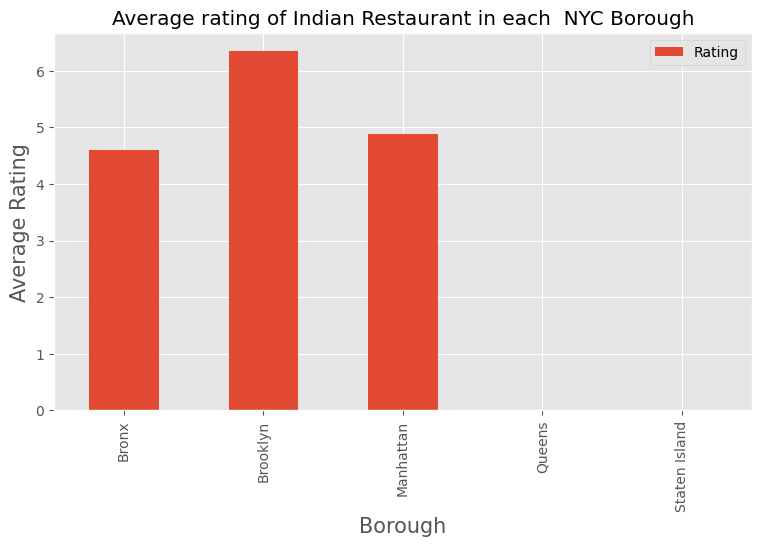

In [34]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Brooklyn has the highest average rating for Indian Restaurants.

### All the neighborhoods with average rating greater or equal 8.0 to be visualized on map

In [35]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [36]:
ny_neighborhood_stats 

,Neighborhood,Average Rating
6,Boerum Hill,8.000000
11,Central Harlem,8.100000
12,Chelsea,8.700000
14,Clinton Hill,8.100000
18,East Flatbush,8.000000
25,Fort Greene,8.500000
31,Greenwich Village,8.900000
42,Manhattan Valley,8.025000
44,Midtown,8.600000
49,Ocean Hill,8.100000


In [37]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [38]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [39]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
14,Manhattan,Tribeca,40.721522,-74.010683,9.10
11,Brooklyn,Prospect Heights,40.676822,-73.964859,8.90
7,Manhattan,Greenwich Village,40.726933,-73.999914,8.90
16,Manhattan,West Village,40.734434,-74.006180,8.85
2,Manhattan,Chelsea,40.744035,-74.003116,8.70
3,Staten Island,Chelsea,40.594726,-74.189560,8.70
12,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.70
9,Manhattan,Midtown,40.754691,-73.981669,8.60
6,Brooklyn,Fort Greene,40.688527,-73.972906,8.50
13,Manhattan,Roosevelt Island,40.762160,-73.949168,8.30


In [40]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [41]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [42]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

#### Best neighbourhoods in New York that has highest average rating for Indian Restaurants.

In [43]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)



#### Findings

1. Murray Hill, Tribeca, Midtown in Manhattan are some of the best neighborhoods for Indian cuisine.
2. Bronx has the lowest rated Indian Resturants in NYC.
3. Manhattan is the best place to stay if you prefer Indian Cuisine.

### Recommendations

Midtown or Tribeca in Manhattan would be the best choice to start a restaurant given that:

1. it is the third most populous urban area in New York City (NYC).
2. it has a population density of 27,826 people per square km, highest of any borough in the United States.
3. it has some of the top rated Indian restaurants located in that area
4. It has the second highest Asian ethnic minority population in NYC.

In [49]:

ny_map = folium.Map(location=geo_location('New York'), zoom_start=11)
#ny_geo = 'geo-boundaries.json'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlGnBu',
    fill_opacity=0.6, 
    line_opacity=0.4,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('rated-map.html')

FileNotFoundError: [Errno 2] No such file or directory: 'geo-boundaries.json'